In [304]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from utils import *

In [305]:
import numpy as np

def generate_X(d, corr_rate, n):
    """Generate Gaussian feature matrix X with Toeplitz covariance."""
    def toep(d, rho):
        """Generate Toeplitz correlation matrix."""
        return np.fromfunction(lambda i, j: rho ** np.abs(i - j), (d, d))

    cov = toep(d, corr_rate)
    X = np.random.multivariate_normal(np.zeros(d), cov, size=n)
    return X

def adjust_beta(X, target_score=0.5, score_threshold=0.01, max_iter=100, initial_beta_variance=1.0):
    """
    Adjust beta to achieve a desired distribution of probabilities p(y=1).

    Parameters:
    - X: Feature matrix (n x d)
    - target_score: Desired score describing the centering of probabilities around 0.5.
    - score_threshold: Threshold for stopping when close enough to the target score.
    - max_iter: Maximum number of iterations for adjusting beta.
    - initial_beta_variance: Initial variance for beta coefficients.

    Returns:
    - beta: Adjusted coefficients.
    - score_history: History of scores during the adjustment process.
    """
    n, d = X.shape
    beta = np.random.normal(0, initial_beta_variance, size=d)
    score_history = []

    for _ in range(max_iter):
        # Compute probabilities
        logits = X @ beta
        probs = 1 / (1 + np.exp(-logits))

        # Compute a score: How "centered" the probabilities are around 0.5
        score = 4 * np.mean(probs * (1 - probs))  # Peaks at 0.5, decreases at 0 or 1
        score_history.append(score)

        # Check if the score is close enough to the target
        if np.abs(score - target_score) < score_threshold:
            break

        # Adjust variance of beta to shift the distribution
        if score < target_score:
            # Probabilities are too extreme (close to 0 or 1), reduce beta variance
            beta *= 0.9
        else:
            # Probabilities are too centered (around 0.5), increase beta variance
            beta += np.random.normal(0, 0.1, size=d)

    return beta, score_history


In [306]:
def sigma(x):
    return 1 / (1 + np.exp(-x))


In [307]:
# Parameters
d = 5
n = 100000
corr_rate = 0.2

# Generate X
X = generate_X(d, corr_rate, n)

# Adjust beta to center probabilities near 0.5
beta0, score_history = adjust_beta(X, target_score=0.60, score_threshold=0.005)
beta1, _ = adjust_beta(X, target_score=0.05, score_threshold=0.0005)
beta2, _ = adjust_beta(X, target_score=0.995, score_threshold=0.0001)

p0 = sigma(X @ beta0)
p1 = sigma(X @ beta1)
p2 = sigma(X @ beta2)


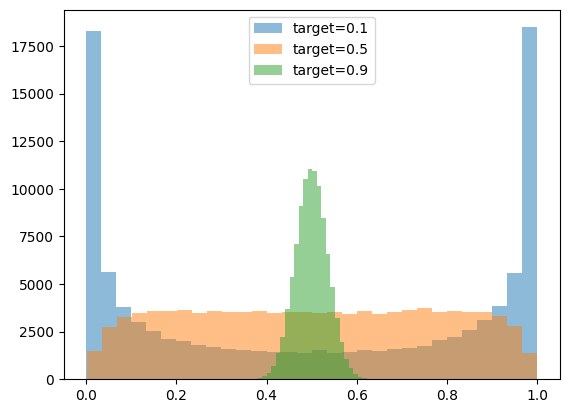

In [308]:
plt.hist(p1, bins=30, alpha=0.5, label='target=0.1')
plt.hist(p0, bins=30, alpha=0.5, label='target=0.5')
plt.hist(p2, bins=30, alpha=0.5, label='target=0.9')
plt.legend()
plt.show()
